In [26]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



%matplotlib inline


In [27]:
# 데이터 불러오기
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## Feature engineering 
- dataset 에 존재하는 null data를 채우고자 한다.
- null data 를 어떻게 채우느냐에 따라 모델의 성능이 달라질 수 있다.
- Feature enginnering은 실제 모델의 학습에 사용되기 때문에, train 뿐 아니라 실제 모델의 학습에 쓰려고 하는 것이므로, 두 데이터 셋 모두 적용해주어야 한다.

## Fill Null

### Fill Null in Embarked
- Age 에는 null data가 177 개가 있다.
- 영어이름의 특성상 이름 앞에 타이틀이 존재한다. 
- 타이틀을 추출해 이용하겠다.

In [28]:
# name 컬럼에서 miss, mr, mrs 등  추출
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [29]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 테이블을 참고하여, 남자, 여자가 쓰는 initail(Miss , Mr, other 로 구분)

In [30]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [31]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관련있는 miss, mrs 가 생존률이 높은 걸 알 수 있음

<AxesSubplot:xlabel='Initial'>

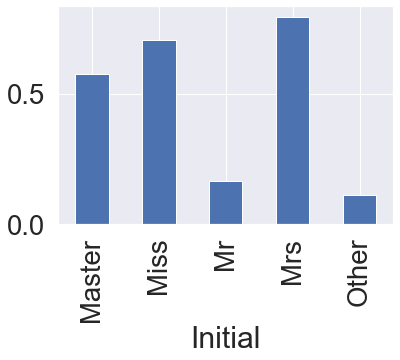

In [32]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- null data 를 채우는 방법은 정말 많이 존재한다. statisitcs를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해 채워넣는 방법도 있다.
- 여기서는 statistics 는 train data 를 활용한다.

In [33]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 각 Initial을 기준으로 Age의 평균을 이용해 Null value를 채우겠다.
- Pandas dataframe 을 다룰 때 boolean array 를 이용해 indexing 하는 방법이 편하다.

In [34]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

- null 을 채우는 다양한 방법을 쓴 예시는 아래 링크 참조
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 

### Fill Null in Embarked

In [35]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


- Embarked 는 Null Values가 2개 이고, S에 가장 많은 탑승객이 있었으므로, 간단하게 Null 값을 S로 채우겠다

In [36]:
df_train['Embarked'].fillna('S', inplace=True)

#### change Age 
- 나이를 연속형 변수에서 범주형 변수로 변경하겠다.

In [37]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [38]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

- apply 를 사용해주면 1번 방법보다 훨씬 수월하게 범주화 가능하다

In [39]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [40]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

### Change Initial, Embarked and Sex(str => num)

- Embarked 도 C,Q,S로 이루어져있다. map 을 이용해 numeric으로 변환한다.

In [41]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [42]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [43]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [44]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [45]:
df_train['Embarked'].isnull().any()

False

- Sex 도 Female, male로 이루어져있다. map을 이용해 변환한다

In [46]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

- 이제 각 feature 간의 상관관계를 살펴본다. 
- 두0 변수간의 피어슨 상관계수를 구하면 (-1, 1) 사이의 값을 얻을 수 있다. 
- -1 로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미한다.

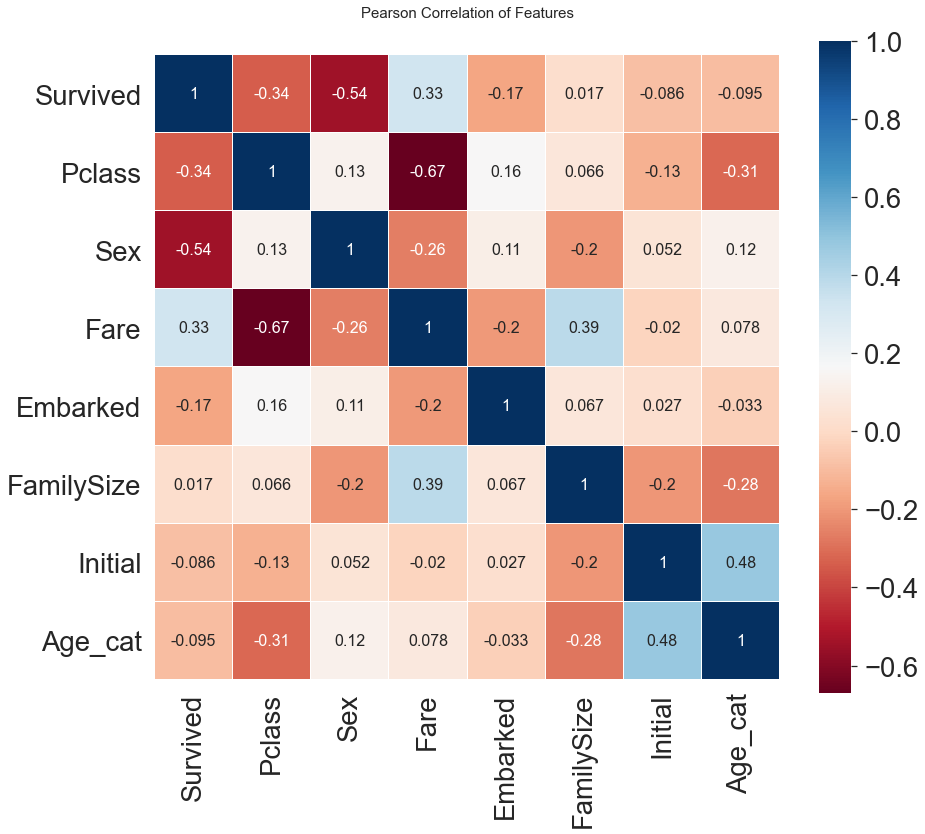

In [47]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

- EDA 에서 살펴봤듯 Sex와 Pclass 가 Survived 와 상관관계가 있음을 확인할 수 있다
- Fare와 Embarked도 상관관계가 있다

### one-hot encoging on Initial and Embarked

- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot ending을 해줄 수 있다.
- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말한다.
- one-hot encoding 은 위 카테고리를 아래와 같이 (0,1) 로 이루어진 5차원의 벡터로 나타내는 것을 의미한다.

In [48]:
df_train = pd.get_dummies(df_train, columns = ['Initial'], prefix = 'Initial')
df_test = pd.get_dummies(df_test, columns = ['Initial'], prefix = 'Initial')

In [49]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


- Embarked 에도 one-hot encoding 사용

In [50]:
df_train = pd.get_dummies(df_train, columns = ['Embarked'], prefix = 'Embarked')
df_test = pd.get_dummies(df_test, columns = ['Embarked'], prefix = 'Embarked')

### Drop columns

In [51]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [52]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


# Building machine learning model and prediction using the trained model

- 이제 sklearn 을 사용해 본격적으로 머신러닝 모델을 만들어 보자

In [53]:
from sklearn.ensemble import RandomForestClassifier

# 모델의 평가를 위해 사용
from sklearn import metrics

# training set 을 쉽게 나눠주는 함수
from sklearn.model_selection import train_test_split

### Preparation - split dataset into train, valid, test set
- 학습에 쓰일 데이터와 target label(Survived)를 분리한다. 
- drop 을 이용해 간단히 할 수 있다.

In [54]:
X_train = df_train.drop('Survived', axis = 1).values
target_label = df_train['Survived'].values
X_test = df_test.values 

In [55]:
X_tr, X_vld, Y_tr, Y_vld = train_test_split(X_train, target_label, test_size = 0.3 ,
                                           random_state = 2018)

### Model generation and prediction

In [56]:
model = RandomForestClassifier()
model.fit(X_tr, Y_tr)
prediction = model.predict(X_vld)

In [57]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(Y_vld.shape[0], 100 * metrics.accuracy_score(prediction, Y_vld)))

총 268명 중 83.58% 정확도로 생존을 맞춤


### Feature importance
- 학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는 지 확인할 수 있다.

In [59]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

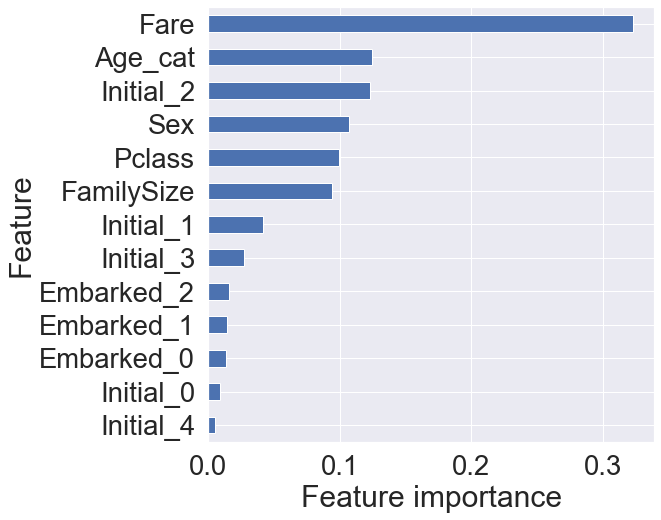

In [61]:
plt.figure(figsize = (8,8))
Series_feat_imp.sort_values(ascending = True).plot.barh()

plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

### pediction on Test set
- 모델이 학습하지 않았던 테스트셋을 모델에 주어, 생존여부를 예측한다.

In [63]:
submission = pd.read_csv('C:/Users/82102/STUDY/titanic/data/submission.csv')

In [64]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [65]:
# 예측

prediction = model.predict(X_test)
submission['Survived'] = prediction

In [66]:
submission.to_csv('./my_first_submission.csv', index=False)

In [68]:
conclusion = pd.read_csv('./my_first_submission.csv')
print(conclusion)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
